In [1]:
import numpy as np
import matplotlib.pyplot as plt

#### Simulation parameters

For the anharmónic case, put $\lambda\neq 0$.

In [2]:
N = 1000            # Number of trajectory points, (x_0, x_1, ..., x_N), recommended from 10^2 to 10^3
epsilon = 0.314     # Step of imaginary time (tau), recommended epsilon*omega/(2*pi) from 1/10 to 1/20
                    # T = N * epsilon (total time)

a = np.sqrt(epsilon)    # Metropolis step proportional to 2*sqrt(epsilon)
N_E = 500               # Number of trajectories to promediate (at least 10^2)

# V(x) = (m/2)omega^2 * x^2 + lambda * x^4
hbar = 1
m = 1
omega = 1
Lambda = 0

##### Potential centered at 0

$$ V(x) = \frac{m}{2} \omega^2 x^2 + \lambda x^4 $$

In [3]:
def V(x):
    return (m/2) * omega**2 * x**2 + Lambda * x**4 

def V_prime(x):
    return m * omega**2 * x + 4 * Lambda * x**3

##### Two well potential at $x=\pm f$

$$ V(x) = \lambda (x^2 - f^2)^2

In [ ]:
f = 2     # Two well potential minima location

def V(x):
    return Lambda * (x**2 - f**2) ** 2

def V_prime(x):
    return 4 * Lambda * x * (x**2 - f**2)

We are going to estimate $E_0$ with the following operator, defined as a functional of the trajectory:

$$ f[x(\tau)] = V[x(\tau)] + \frac{1}{2}x(\tau)V'[x(\tau)] $$

In [4]:
def f_local(x):
    return V(x) + (1/2) * x * V_prime(x)

#### Metropolis algorithm

We approximate the euclidean action as:

$$ S_\mathrm{E}[x(\tau)] = \int_0^T d\tau\,H[x(\tau)] \approx \epsilon\sum_{i=0}^{N-1} \left[\frac{m}{2}\left(\frac{x_{i+1} - x_i}{\epsilon}\right)^2 + V\left(\frac{x_{i+1} + x_i}{2}\right)\right]. $$

So the difference between the new action value and the old one is:

$$\Delta S_\mathrm{E} = \epsilon \left[\frac{m}{2}\left(\frac{x'_i - x_{i-1}}{\epsilon}\right)^2 + V\left(\frac{x'_i + x_{i-1}}{2}\right) + \frac{m}{2}\left(\frac{x_{i+1} - x'_i}{\epsilon}\right)^2 + V\left(\frac{x_{i+1} + x'_i}{2}\right)\right] - \epsilon \left[\frac{m}{2}\left(\frac{x_i - x_{i-1}}{\epsilon}\right)^2 + V\left(\frac{x_i + x_{i-1}}{2}\right) + \frac{m}{2}\left(\frac{x_{i+1} - x_i}{\epsilon}\right)^2 + V\left(\frac{x_{i+1} + x_i}{2}\right)\right]
$$

In [5]:
def delta_S(x, i, new_pos):
    """
    Computes the change in the Euclidean Action when altering the trajectory x[i] -> new_pos.

    It assumes periodic boundary condition x_0 = x_N.
    """
    # Computing old and new index, with boundary condition in mind (mod N)
    im1 = (i - 1) % N
    ip1 = (i + 1) % N

    # Deltas viejos
    dx1_old = x[i] - x[im1]
    dx2_old = x[ip1] - x[i]
    midpoint1_old = (x[i] + x[im1]) / 2
    midpoint2_old = (x[ip1] + x[i]) / 2

    # Deltas nuevos
    dx1_new = new_pos - x[im1]
    dx2_new = x[ip1] - new_pos
    midpoint1_new = (new_pos + x[im1]) / 2
    midpoint2_new = (x[ip1] + new_pos) / 2

    # We only need to compute the discretized term of the action related to position i
    old_term = epsilon * (
        (m / 2) * (dx1_old / epsilon)**2 + V(midpoint1_old) +
        (m / 2) * (dx2_old / epsilon)**2 + V(midpoint2_old)
    )
    new_term = epsilon * (
        (m / 2) * (dx1_new / epsilon)**2 + V(midpoint1_new) +
        (m / 2) * (dx2_new / epsilon)**2 + V(midpoint2_new)
    )

    return new_term - old_term

In the article by Creutz and Freedman, however, it is taken instead:

$$ S_\mathrm{E}[x(\tau)] = \int_0^T d\tau\,H[x(\tau)] \approx \epsilon\sum_{i=0}^{N-1} \left[\frac{m}{2}\left(\frac{x_{i+1} - x_i}{\epsilon}\right)^2 + V(x_i)\right] $$

$$\Delta S_\mathrm{E} = \epsilon \left[\frac{m}{2}\left(\frac{x'_i - x_{i-1}}{\epsilon}\right)^2 + V(x'_i) + \frac{m}{2}\left(\frac{x_{i+1} - x'_i}{\epsilon}\right)^2 \right]
- \epsilon \left[\frac{m}{2}\left(\frac{x_i - x_{i-1}}{\epsilon}\right)^2 + V(x_i) + \frac{m}{2}\left(\frac{x_{i+1} - x_i}{\epsilon}\right)^2 \right]$$

In [ ]:
def delta_S(x, i, new_pos):
    """
    Computes the change in the Euclidean Action when altering the trajectory x[i] -> new_pos.

    It assumes periodic boundary condition x_0 = x_N.
    """
    # Computing old and new index, with boundary condition in mind (mod N)
    im1 = (i - 1) % N
    ip1 = (i + 1) % N

    # Deltas viejos
    dx1_old = x[i] - x[im1]
    dx2_old = x[ip1] - x[i]

    # Deltas nuevos
    dx1_new = new_pos - x[im1]
    dx2_new = x[ip1] - new_pos

    # We only need to compute the discretized term of the action related to position i
    old_term = epsilon * (
        (m / 2) * (dx1_old / epsilon)**2 + V(x[i]) +
        (m / 2) * (dx2_old / epsilon)**2
    )
    new_term = hbar * (
        (m / 2) * (dx1_new / epsilon)**2 + V(new_pos) +
        (m / 2) * (dx2_new / epsilon)**2
    )

    return new_term - old_term

In [13]:
def metropolis_sweep(x):
    """
    A metropolis sweep consists on alterating a trajectory x = (x_0, x_1, ... , x_{N-1}) to a new 
    one x' = (x'_0, x'_1, ..., x'_{N-1}) with a metropolis step of 'a' and acceptance probability 
    given by the change in the Euclidean Action. 

    It assures x'_0 = x'_{N-1}.
    """
    accepted = 0

    # We change every trajectory sample, from 0 to N-2
    n = 10
    for i in range(N-1):
        for _ in range(n):
            trial_pos = x[i] + np.random.uniform(-a, a)
            dS = delta_S(x, i, trial_pos)
            if np.random.rand() < np.exp(-dS / hbar):
                x[i] = trial_pos
                accepted += 1     
        n = 1

    # We enforce the periodic boundary conditions still holds
    x[N-1] = x[0]

    acceptance_ratio = accepted / (N - 1)

    return x, acceptance_ratio

In [12]:
def generate_trajectories():
    """
    Generates 'N_E' (more or less) statistically independent trajectories. 
    """
    trajectories = np.zeros((N_E, N))
    x = np.random.normal(0.0, 1.0, N)  # Initial trajectory

    acc_ratios = []

    # Computes N_E trajectories and saves the value of f_local for each one
    for j in range(N_E):
        
        # Thermalization (3-5 discarded trajectories)
        for _ in range(5):
            x, acc = metropolis_sweep(x)
            acc_ratios.append(acc)
        
        trajectories[j, :] = x

    mean_acceptance = np.mean(acc_ratios)
    print(f"→ Acceptance ratio: {mean_acceptance:.2%} (target ~70%)")

    return trajectories

In [8]:
def calculate_observables(trajectories):
    """
    Computes the observables for a number 'N_E' of trajectories.
    """
    observables = np.zeros((N_E, N))
    
    for j in range(N_E):
        x = trajectories[j]
        observables[j, :] = f_local(x)

    return observables

In [9]:
def analyze_observables(observables):
    """
    Computes the estimator of E_0 for a number 'N_E' of trajectories.
    """
    f_bar_tau = np.mean(observables, axis=0)
    s_f_tau = np.std(observables, axis=0)
    f_bar_bar = np.mean(f_bar_tau)
    s_f_bar = np.std(f_bar_tau)

    return f_bar_tau, s_f_tau, f_bar_bar, s_f_bar

#### Numerical results

In [14]:
# Fixing the seed for reproducibility of data
# np.random.seed(42)

print("Simulating... Please wait.")
trajectories = generate_trajectories()
observables = calculate_observables(trajectories)
f_bar, s_f, E0, dE0 = analyze_observables(observables)

print(f"\nEstimated E0: {E0:.6f} ± {dE0:.6f}\n")

Simulating... Please wait.
→ Acceptance ratio: 73.22% (target ~70%)

Estimated E0: 0.498622 ± 0.081768



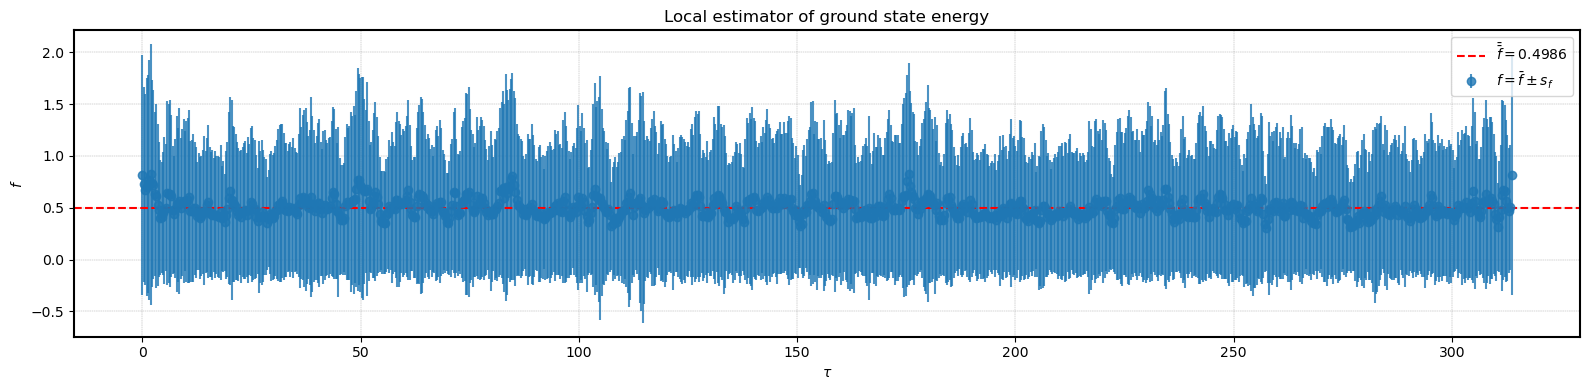

In [17]:
tau_values = np.arange(N) * epsilon
fig, ax = plt.subplots(figsize=(16, 4))
ax.spines['top'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
plt.errorbar(tau_values, f_bar, yerr=s_f, fmt='o', alpha=0.8, label=r"$f=\bar{f}\pm s_f$")
plt.axhline(E0, color='r', linestyle='--', label=rf"$\bar{{\bar{{f}}}} = {E0:.4f}$")
plt.xlabel(r"$\tau$")
plt.ylabel(r"$f$")
plt.title("Local estimator of ground state energy")
plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.3, alpha=0.8)
plt.tight_layout()
plt.show()

In [19]:
def plot_ground_state_histogram(trajectories, delta_x=0.1, x_min=-3, x_max=3, bins=None):
    """
    Calculates and plots the histogram of |\psi_0(x)|^2 from a list of trajectories.
    It returns
    - bin_centers: central position of the bins.
    - hist_density: normalized values of the histogram (probability density).
    """
    data = trajectories.flatten()

    if bins is None:
        bins = int((x_max - x_min) / delta_x)

    counts, edges = np.histogram(data, bins=bins, range=(x_min, x_max))
    bin_width = edges[1] - edges[0]
    bin_centers = edges[:-1] + bin_width / 2

    hist_density = counts / (counts.sum() * bin_width)

    errors = np.sqrt(counts) / (counts.sum() * bin_width)

    fig, ax = plt.subplots()
    ax.spines['top'].set_linewidth(1.5)
    ax.spines['right'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)

    plt.bar(bin_centers, hist_density, width=bin_width, align='center', alpha=0.7, label=r"$|\psi_0(x)|^2$")
    plt.errorbar(bin_centers, hist_density, yerr=errors, fmt='none', ecolor='black', capsize=2)
    plt.xlabel(r"$x$")
    plt.ylabel(r"Probability density")
    plt.title("Ground state approximated histogram")
    plt.grid(color='gray', linestyle='--', linewidth=0.3, alpha=0.8)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return bin_centers, hist_density

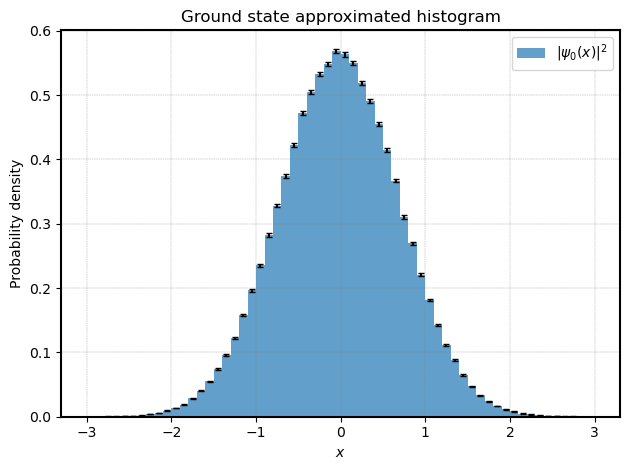

(array([-2.95, -2.85, -2.75, -2.65, -2.55, -2.45, -2.35, -2.25, -2.15,
        -2.05, -1.95, -1.85, -1.75, -1.65, -1.55, -1.45, -1.35, -1.25,
        -1.15, -1.05, -0.95, -0.85, -0.75, -0.65, -0.55, -0.45, -0.35,
        -0.25, -0.15, -0.05,  0.05,  0.15,  0.25,  0.35,  0.45,  0.55,
         0.65,  0.75,  0.85,  0.95,  1.05,  1.15,  1.25,  1.35,  1.45,
         1.55,  1.65,  1.75,  1.85,  1.95,  2.05,  2.15,  2.25,  2.35,
         2.45,  2.55,  2.65,  2.75,  2.85,  2.95]),
 array([1.40002800e-04, 1.60003200e-04, 3.20006400e-04, 4.00008000e-04,
        1.18002360e-03, 1.40002800e-03, 2.02004040e-03, 3.90007800e-03,
        5.56011120e-03, 9.46018920e-03, 1.33002660e-02, 1.88803776e-02,
        2.83405668e-02, 4.04808096e-02, 5.49610992e-02, 7.39614792e-02,
        9.59619192e-02, 1.21862437e-01, 1.57903158e-01, 1.96523930e-01,
        2.35524710e-01, 2.82525651e-01, 3.28326567e-01, 3.74067481e-01,
        4.22888458e-01, 4.72269445e-01, 5.05070101e-01, 5.33090662e-01,
        5.47890958

In [25]:
plot_ground_state_histogram(trajectories)

In [ ]:
def compute_first_excited_energy(trajectories, delta_tau_steps=1):
    correlations = []
    for tau in range(N - delta_tau_steps):
        x0_xt = np.mean([traj[0] * traj[tau] for traj in trajectories])
        x0_xt_dtau = np.mean([traj[0] * traj[tau + delta_tau_steps] for traj in trajectories])
        if x0_xt > 0 and x0_xt_dtau > 0:
            corr_ratio = x0_xt_dtau / x0_xt
            delta_tau = epsilon * delta_tau_steps
            E1 = -np.log(corr_ratio) / delta_tau + E0
            correlations.append((tau * epsilon, E1))

    return correlations

#### Trajectory plotter

In [17]:
N = 50

def plot_sample_trajectory():
    """
    Generates and plots a single quantum trajectory after thermalization (Feynman-style).
    Saves the plot to file.
    """
    x = np.random.normal(0.0, 1.0, N)
    x[N-1] = x[0]  # enforce periodic boundary

    for _ in range(20):
        x, acceptance_ratio  = metropolis_sweep(x)
    
    tau = np.arange(N) * epsilon

    fig, ax = plt.subplots(figsize=(4, 8))
    ax.plot(x, tau, '-o', markersize=3)
    
    # Gridlines for discrete time steps
    for t in tau:
        ax.axhline(t, color='gray', linestyle='--', linewidth=0.3, alpha=0.8)

    # Vertical line marking x_0 == x_{N-1}
    ax.axvline(x[0], color='tab:orange', linestyle='--', linewidth=1.2, alpha=0.7)

    ax.set_title("Sample quantum trajectory", fontsize=12)
    ax.spines['top'].set_linewidth(1.5)
    ax.spines['right'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)

    # Annotate discretization info
    ax.text(0.05, 0.95, f"$N = {N}$ \n $\\epsilon = {epsilon:.4f}$",
            transform=ax.transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))

    # Hide ticks and labels for a cleaner Feynman-style appearance
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("$x(\\tau)$")
    ax.set_ylabel("$\\tau$")

    plt.tight_layout()
    plt.savefig("sample_trajectory.png")
    plt.show()

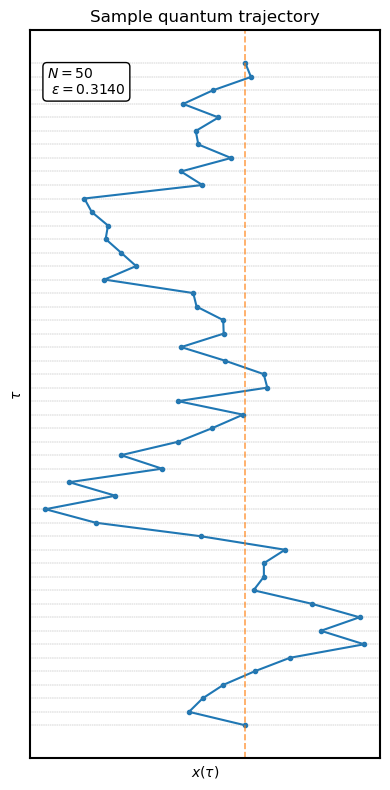

In [18]:
plot_sample_trajectory()